In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time
from mpl_toolkits.mplot3d import Axes3D
import pickle

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

def grid_finder(X_grid, Y_grid, ic, jc, r):
    center_x = X_grid[ic, jc]
    i_left = 0
    while center_x - X_grid[ic - i_left, jc] < r:
        i_left += 1

    i_right = 0
    while X_grid[ic + i_right, jc] - center_x < r:
        i_right += 1

    center_y = Y_grid[ic, jc]
    j_down = 0
    while center_y - Y_grid[ic, jc - j_down] < r:
        j_down += 1

    j_up = 0
    while Y_grid[ic, jc + j_up] - center_y < r:
        j_up += 1

    return i_left, i_right, j_down, j_up 

def plot_ellipse(Q, center=(0, 0), scale=1):
    # def normalize_matrix(A, norm_type='fro'):
    #     norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
    #     return A / norm if norm else A
    # Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):
        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
            
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse


In [2]:
df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")
df_eddies


Day    ID Cyc         Lon        Lat   ic   jc          x0  \
0        1462     1  CE  161.093546 -29.714998  261  275  929.532120   
1        1463     1  CE  160.871720 -29.764770  258  273  910.409810   
2        1464     1  CE  160.922307 -29.791470  259  272  915.918179   
3        1465     1  CE  160.955011 -29.644446  259  276  914.513286   
4        1466     1  CE  160.900960 -29.634113  258  276  909.171353   
...       ...   ...  ..         ...        ...  ...  ...         ...   
132634  10646  2962  CE  155.090978 -40.102161  223   14  708.322310   
132635  10647  2962  CE  154.836115 -40.385267  220    6  695.611882   
132636  10648  2962  CE  154.979715 -40.569836  223    3  712.690769   
132637  10649  2962  CE  155.150873 -40.263961  224   11  717.914731   
132638  10650  2962  CE  154.375144 -40.385112  213    3  657.889455   

                 y0       q11       q12       q22         w  Age  \
0       1359.081341 -0.002460  0.001192 -0.003187 -0.011293  107   
1       1346.368459 -0.006279  0.001039 -0.002655 -0.017868  107   
2       1345.231552 -0.003853  0.000654 -0.002549 -0.012804  107   
3       1361.918280 -0.004816  0.001225 -0.003001 -0.015635  107   
4       1361.201101 -0.003874  0.001326 -0.003299 -0.014347  107   
...             ...       ...       ...       ...       ...  ...   
132634    67.634123 -0.002455 -0.000032 -0.001645 -0.008201   28   
132635    30.128608 -0.001272  0.000185 -0.001351 -0.005245   28   
132636    14.777712 -0.001122  0.000260 -0.001881 -0.006006   28   
132637    52.244946 -0.001737 -0.000091 -0.001655 -0.006783   28   
132638    16.616868 -0.000580 -0.000036 -0.001433 -0.004027   28   

                                                    fname  
0       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
1       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
2       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
3       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
4       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
...                                                   ...  
132634  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
132635  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
132636  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
132637  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
132638  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  

[132639 rows x 15 columns]

### Vertical Dataset of Centers

In [3]:
def dopioe(ic, jc, r, u, v, X, Y):

    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]
    
    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    # Vertical profile along column njc
    center_x = X[ic, jc]

    i_left = 0
    left_x = X[ic - i_left, jc]
    while center_x - left_x < r:
        i_left += 1
        if ic - i_left < 0:
            break
        
        left_x = X[ic - i_left, jc]
        
    i_right = 0
    right_x = X[ic + i_right, jc]
    while right_x - center_x < r:
        i_right += 1
        if ic + i_right >= X.shape[0]:
            break

        right_x = X[ic + i_right, jc]

    u1 = u[ic - i_left: ic + i_right + 1, jc]
    v1 = v[ic - i_left: ic + i_right + 1, jc]
    x1 = X[ic - i_left: ic + i_right + 1, jc]
    y1 = Y[ic - i_left: ic + i_right + 1, jc]
        
    xx = x1 - center_x

    # Horizontal profile along row nic
    center_y = Y[ic, jc]

    j_down = 0
    down_y = Y[ic, jc - j_down]
    while center_y - down_y < r:
        j_down += 1
        if jc - j_down < 0:
            break
        
        down_y = Y[ic, jc - j_down]
        
    j_up = 0
    up_y = Y[ic, jc + j_up]
    while up_y - center_y < r:
        j_up += 1
        if jc + j_up >= X.shape[1]:
            break
        
        up_y = Y[ic, jc + j_up]

    if (jc - j_down < 0) or (jc + j_up + 1 > X.shape[1]):
        return np.nan, np.nan, np.nan, np.nan
    
    u2 = u[ic, jc - j_down: jc + j_up + 1]
    v2 = v[ic, jc - j_down: jc + j_up + 1]
    x2 = X[ic, jc - j_down: jc + j_up + 1]
    y2 = Y[ic, jc - j_down: jc + j_up + 1]

    yy = y2 - center_y

    # print(i_left, i_right, j_down, j_up)

    if np.any(np.isnan(u1)) or np.any(np.isnan(u2)):
        return np.nan, np.nan, np.nan, np.nan

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, Q

def espra(xi, yi, ui, vi):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.array([[np.nan, np.nan], [np.nan, np.nan]]), np.nan
    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])
    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 
    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    w = 2*(q11 + q22)
    Q = np.array([[q11, q12], [q12, q22]])
    return x0, y0, Q, w

    

#### Sample
AE Downstream: 2749, 8
\
AE Upstream: 2504, 896
\
CE Downstream: 1394, 382
\
CE Upstream: 1967, 926 (reasonable)


In [4]:
def compute_tilt(df_eddies, eddy, X, Y, z_r, method_function, method):

    df = df_eddies[df_eddies['ID'] == eddy].copy()
    dic_tilt = {f'Eddy{eddy}': {}}
    fnumber_old = None
    timer = 0

    for t, data in df.iterrows():
        day, fname, xc_surf, yc_surf, w_surf = data['Day'], data['fname'], data['x0'], data['y0'], data['w']
        fnumber = fname[-8:-3]

        # Only load if file changes
        if fnumber != fnumber_old:
            u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
            v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
            u_raw = np.where(u_raw > 1e30, np.nan, u_raw).astype(float)
            v_raw = np.where(v_raw > 1e30, np.nan, v_raw).astype(float)
            with nc.Dataset(fname) as dataset:
                ocean_time = dataset.variables['ocean_time'][:].data / 86400
            fnumber_old = fnumber
        t_rel = np.where(ocean_time == day)[0][0]

        u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

        df_tilt = []
        x0, y0 = xc_surf, yc_surf
        x0_old, y0_old = xc_surf, yc_surf

        # for k in range(24):
        for k in range(u_t.shape[-1]):
            u, v = u_t[:, :, k], v_t[:, :, k]

            R_grid = np.hypot(x0 - X, y0 - Y)
            ic, jc = map(int, np.unravel_index(np.argmin(R_grid), R_grid.shape))

            if method == 'DOPIOE':
                x0, y0, w, Q = method_function(ic, jc, 20, u, v, X, Y)

            elif method == 'ESPRA':
                mask = np.hypot(X - X[ic, jc], Y - Y[ic, jc]) < 20
                x0, y0, Q, w = method_function(X[mask], Y[mask], u[mask], v[mask])

            if (np.sign(w) != np.sign(w_surf)) or (np.hypot(x0_old - x0, y0_old - y0) > 50):
                break
            else:
                x0_old, y0_old = x0, y0

            df_tilt.append({
                'x': x0, 'y': y0, 'Q': Q, 'w': w,
                'z': k, 'Depth': z_r[150, 150, k]
            })

        if df_tilt:
            df_tilt = pd.DataFrame(df_tilt)
            dx = df_tilt['x'].diff()
            dy = df_tilt['y'].diff()
            df_tilt['TD'] = np.hypot(df_tilt['x'] - df_tilt.iloc[0]['x'],
                                  df_tilt['y'] - df_tilt.iloc[0]['y'])
            df_tilt['Grad'] = dy / dx
            dic_tilt[f'Eddy{eddy}'][f'Day{day}'] = df_tilt

        # if t % max(1, len(df) // 4) == 0:
        #     print(f'{timer*25}% completed')
        #     timer += 1

    # print('100% completed')
    return dic_tilt

### Gather Sample Data

In [5]:
sample_eddies = [2749, 8, 2504, 896, 1394, 382, 1967, 926]

# dic_sample = {}
# for e, eddy in enumerate(sample_eddies):
#     dic = compute_tilt(df_eddies, eddy, X_grid, Y_grid, z_r, dopioe, 'DOPIOE')
#     dic_sample = dic_sample | dic 
#     print(f'{e+1}/{len(sample_eddies)}')

# with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'wb') as f:
#     pickle.dump(dic_sample, f)

with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)


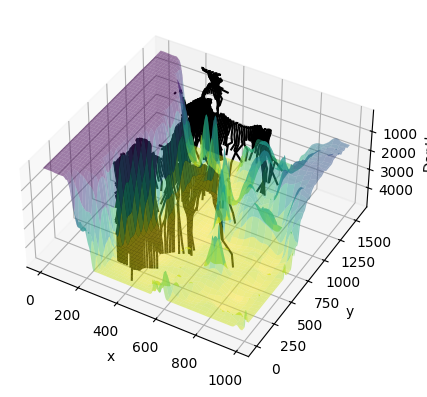

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.plot_surface(X_grid, Y_grid, h, cmap='viridis', alpha=0.5)

# Plot each eddy trajectory
spacing = 1
for eddy in dic_sample:
    dic_eddy = dic_sample[eddy]
    for day in dic_eddy:
        df = dic_eddy[day]
        ax.plot(df['x'][::spacing], df['y'][::spacing], -df['Depth'][::spacing], color='k')

# View and formatting
ax.view_init(elev=40, azim=300)
ax.set_box_aspect((1, 1, 0.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Depth')
ax.invert_zaxis()

plt.show()




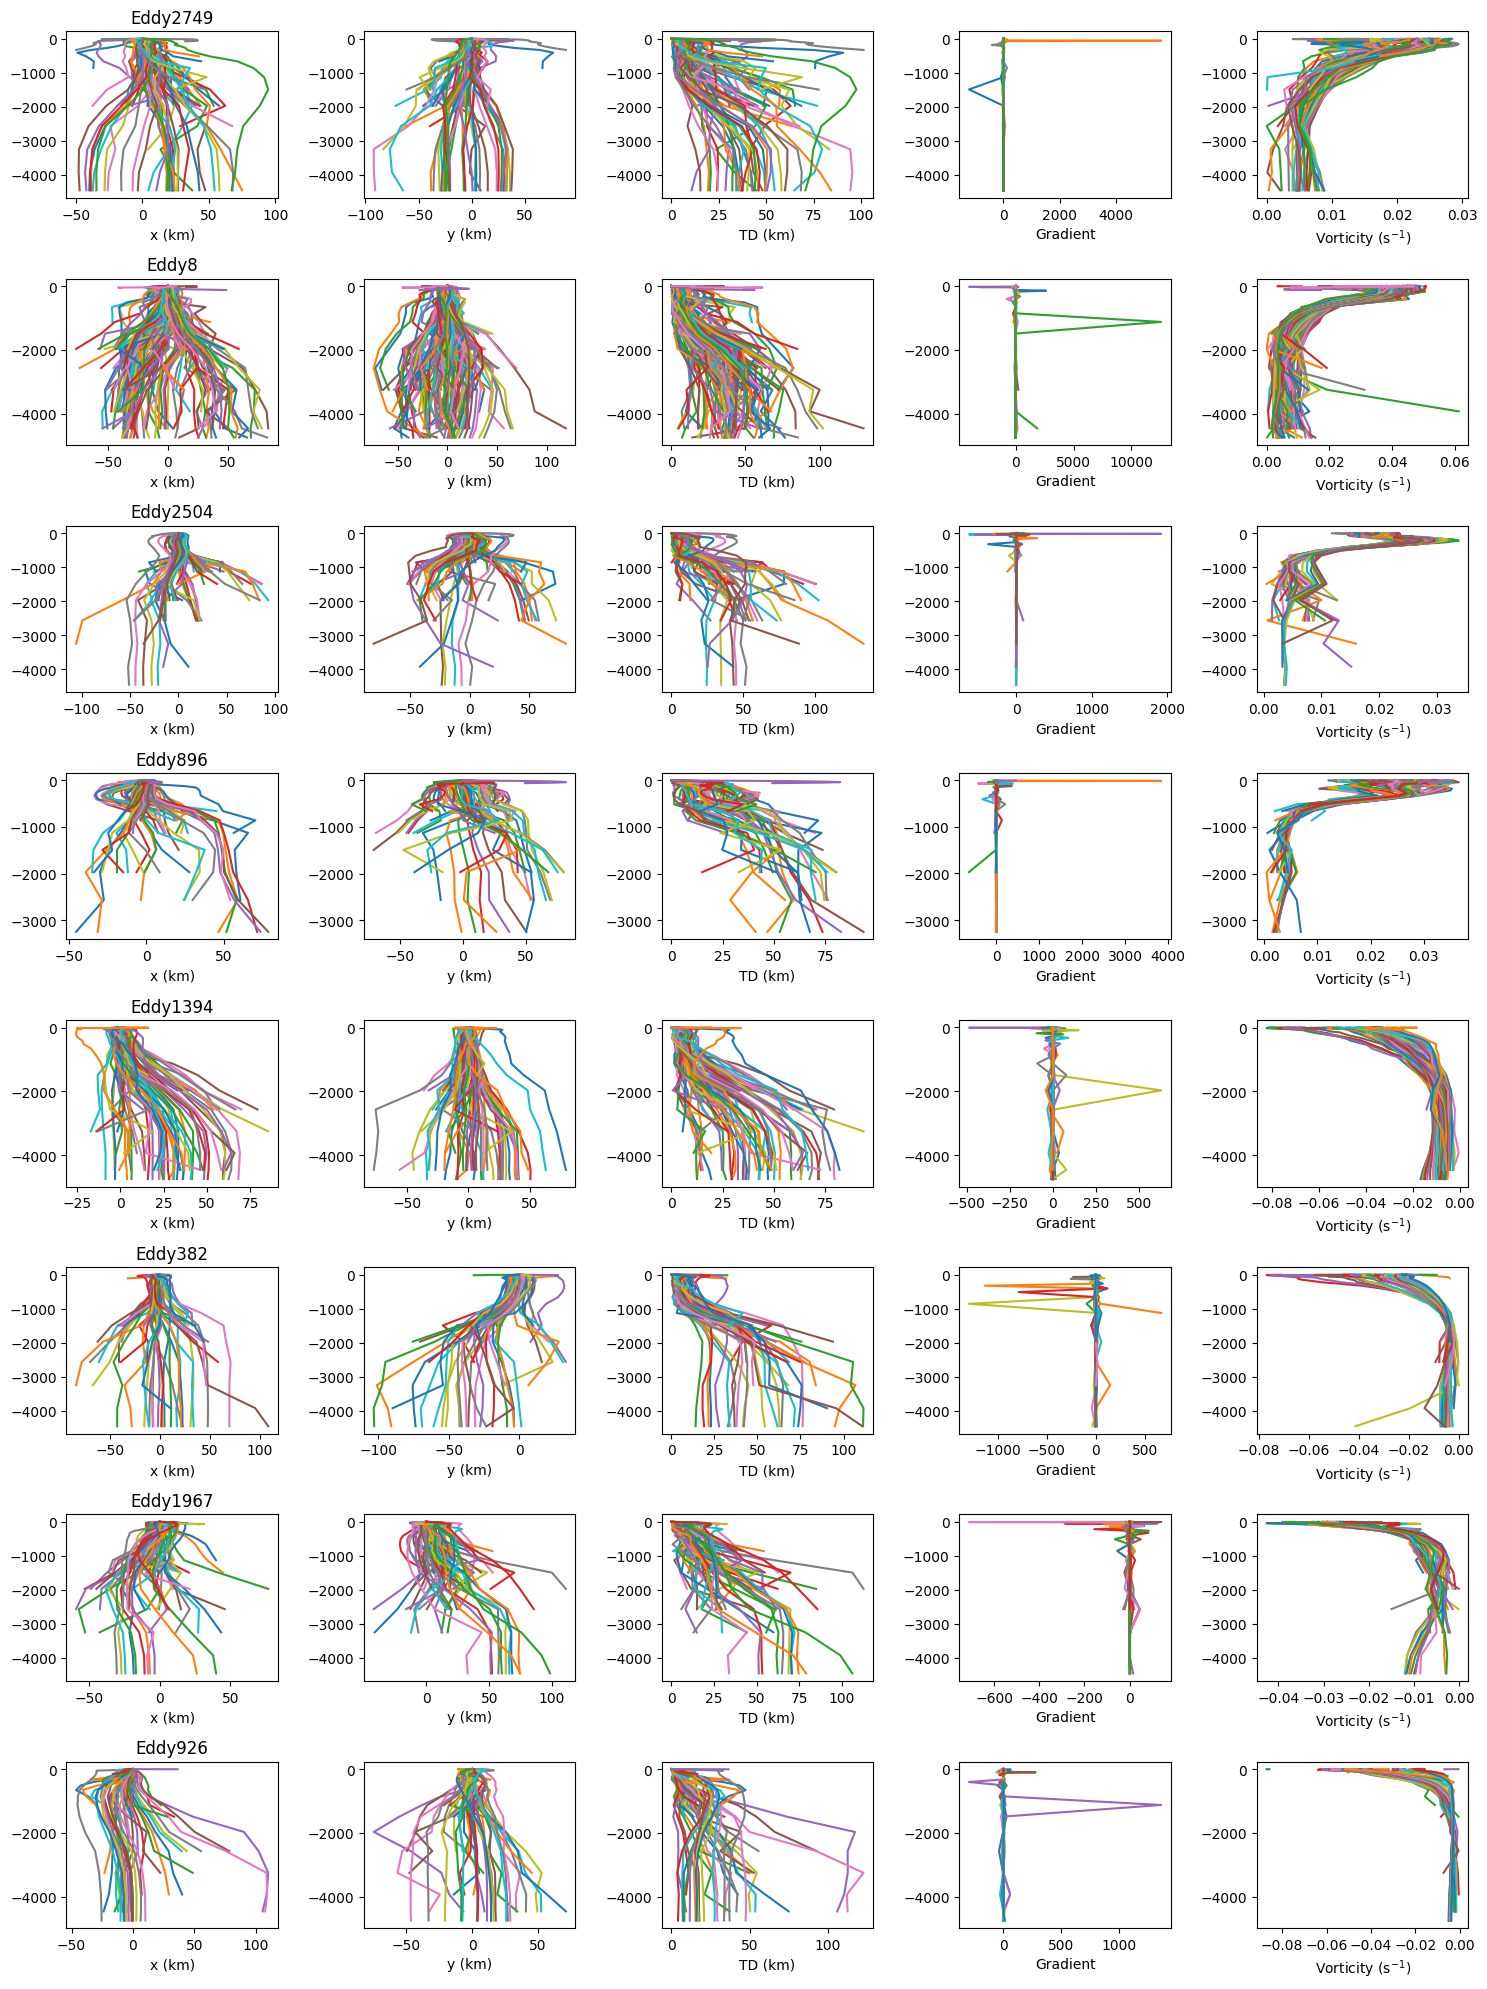

In [7]:
fig, axs = plt.subplots(8, 5, figsize=(15,20))

for e, eddy in enumerate(dic_sample):
    dic_eddy = dic_sample[eddy]
    for day in dic_eddy:
        df = dic_eddy[day]
        axs[e,0].plot(df['x']-df.iloc[0]['x'], df['Depth'])
        axs[e,0].set_xlabel('x (km)')
        axs[e,1].plot(df['y']-df.iloc[0]['y'], df['Depth'])
        axs[e,1].set_xlabel('y (km)')
        axs[e,2].plot(df['TD'], df['Depth'])
        axs[e,2].set_xlabel('TD (km)')
        axs[e,3].plot(df['Grad'], df['Depth'])
        axs[e,3].set_xlabel('Gradient')
        axs[e,4].plot(df['w'], df['Depth'])
        axs[e,4].set_xlabel(r'Vorticity (s$^{-1}$)')
        axs[e,0].set_title(eddy)

plt.tight_layout()
plt.show()

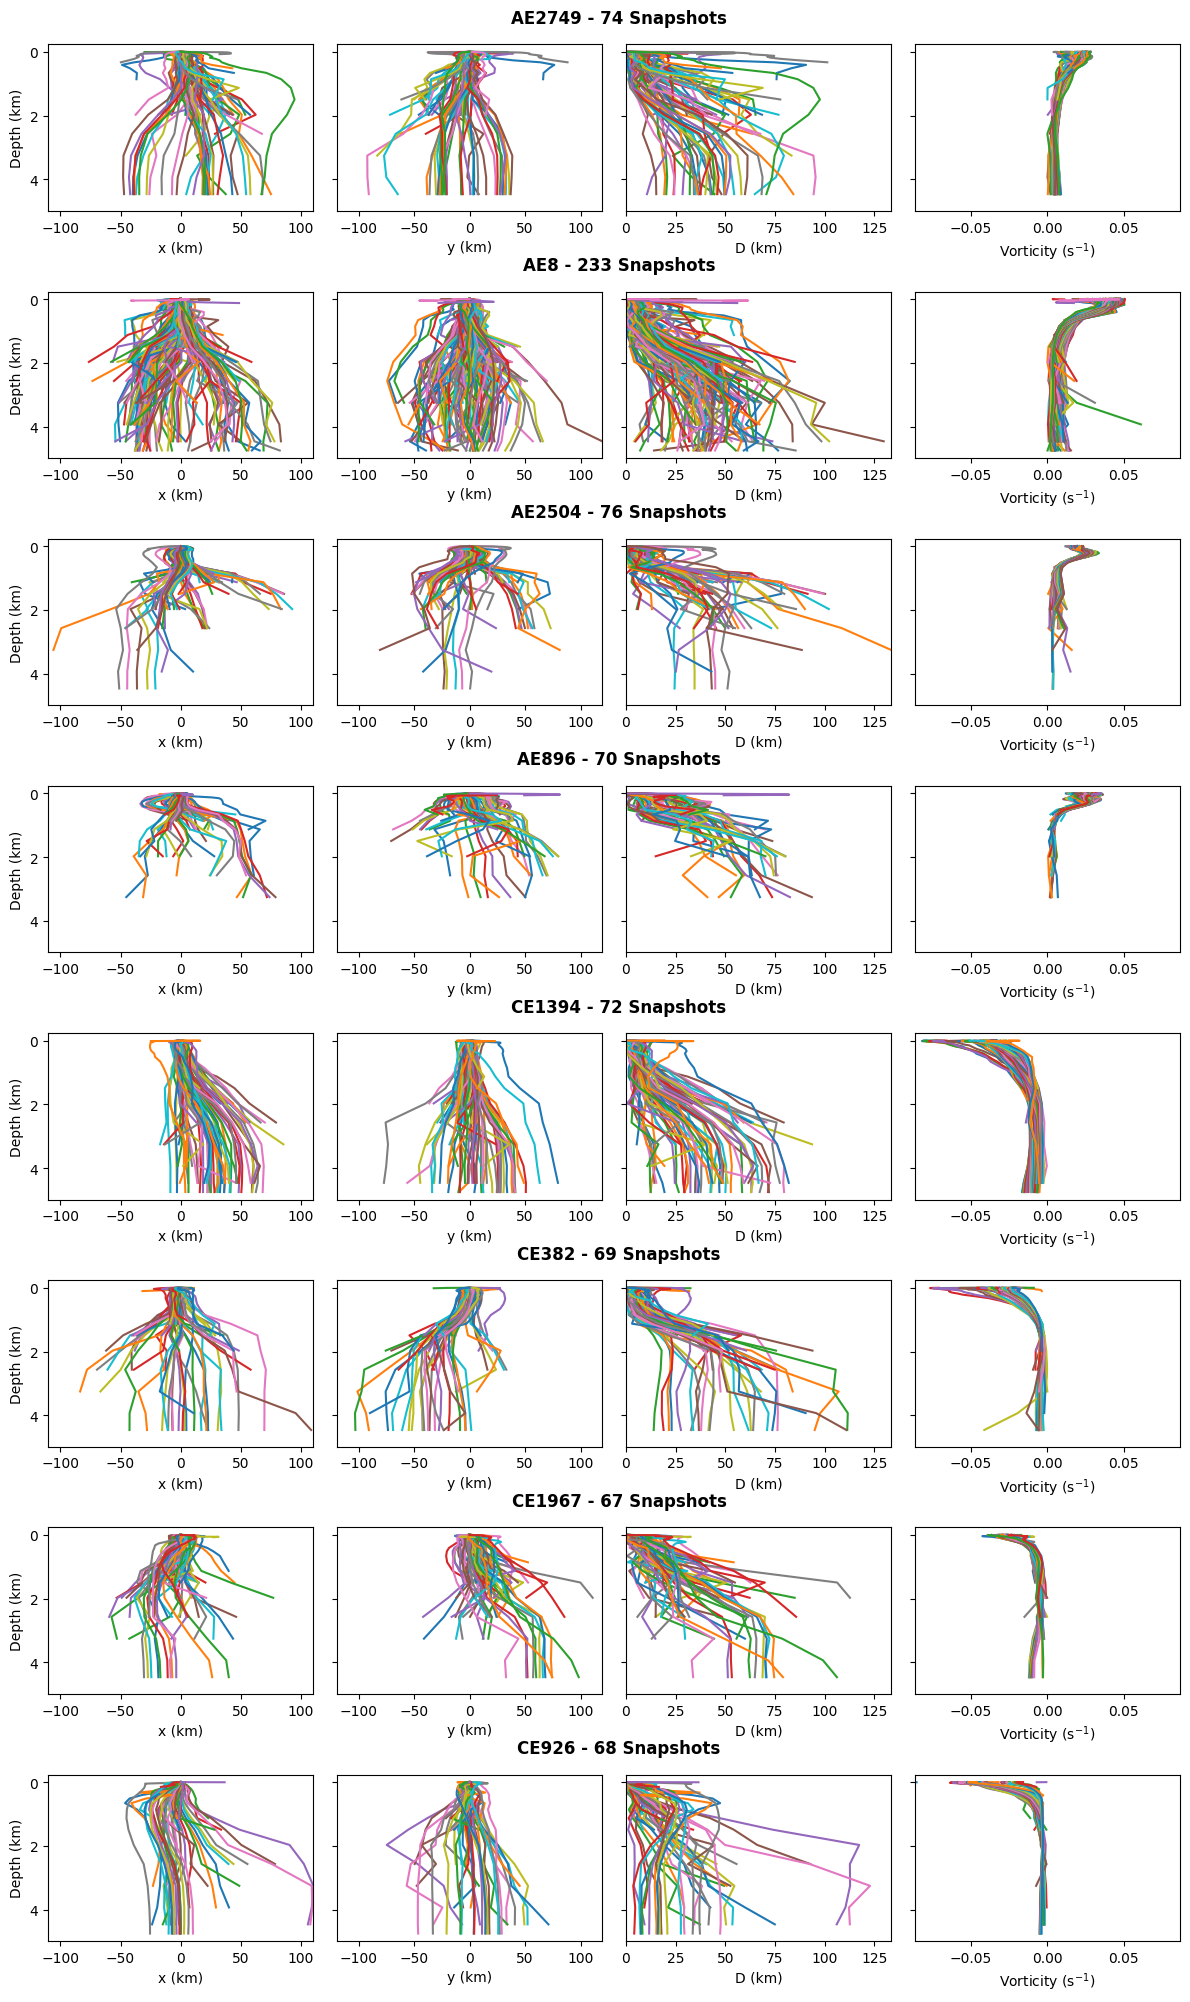

In [8]:
fig, axs = plt.subplots(8, 4, figsize=(12, 20), sharey=True)

xlims = [[] for _ in range(4)]

txt_pos = np.flip(np.linspace(0.125, .99, 8))
for e, eddy in enumerate(dic_sample):
    dic_eddy = dic_sample[eddy]
    for day in dic_eddy:
        df = dic_eddy[day]
        x0 = df.iloc[0]['x']
        y0 = df.iloc[0]['y']

        dx = df['x'] - x0
        dy = df['y'] - y0
        TD = df['TD']
        w = df['w']
        z = -df['Depth'] / 1000

        axs[e, 0].plot(dx, z)
        axs[e, 1].plot(dy, z)
        axs[e, 2].plot(TD, z)
        axs[e, 3].plot(w, z)

        xlims[0].extend(dx)
        xlims[1].extend(dy)
        xlims[2].extend(TD)
        xlims[3].extend(w)

        axs[e, 0].set_xlabel('x (km)')
        axs[e, 1].set_xlabel('y (km)')
        axs[e, 2].set_xlabel('D (km)')
        axs[e, 3].set_xlabel(r'Vorticity (s$^{-1}$)')
    axs[e, 0].set_title('D', color='w')
    row_pos = 1 - (e + 0.5) / 8 - .10  # assuming 8 rows
    cyc = df_eddies[df_eddies['ID'] == int(eddy[4:])].iloc[0].Cyc
    age = df_eddies[df_eddies['ID'] == int(eddy[4:])].iloc[0].Age
    fig.text(0.52, txt_pos[e], f'{cyc}{eddy[4:]} - {age} Snapshots', ha='center', va='bottom',
             fontsize='large', fontweight='bold')
    axs[e, 0].set_ylabel('Depth (km)')

axs[0,0].invert_yaxis()

# Set xlims (columns 0,1,3 centered at 0)
for col in range(4):
    if col in [0, 1, 3]:
        lim = np.nanmax(np.abs(xlims[col]))
        lims = (-lim, lim)
    else:
        lims = (np.nanmin(xlims[col]), np.nanmax(xlims[col]))
    for row in range(8):
        axs[row, col].set_xlim(lims)


plt.tight_layout()
plt.show()


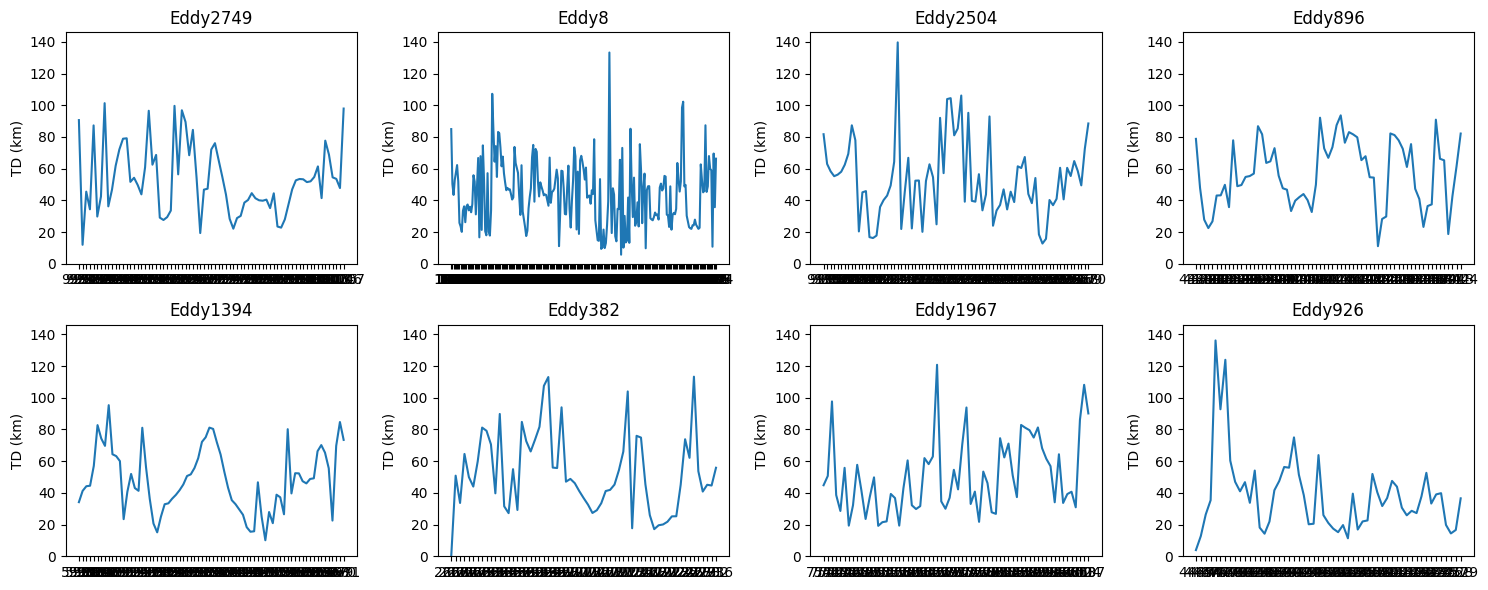

In [9]:
df_TD = pd.DataFrame(columns=['Eddy', 'Day', 'TD'])
for eddy in dic_sample:
    dic_eddy = dic_sample[eddy]
    for day in dic_eddy:
        df = dic_eddy[day]
        TD = np.hypot(df['x'].max()-df['x'].min(), df['y'].max()-df['y'].min())
        df_TD.loc[len(df_TD)] = {'Eddy': eddy[4:], 'Day': day[3:], 'TD': TD}

fig, axs = plt.subplots(2, 4, figsize=(15,6))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    
    df = df_TD[df_TD['Eddy']==str(eddy)]
    ax.plot(df['Day'], df['TD'])
    ax.set_title(f'Eddy{eddy}')
    ax.set_ylabel('TD (km)')

ymax = max(ax.get_ylim()[1] for ax in axs.flat)
for ax in axs.flat:
    ax.set_ylim(0, ymax)

plt.tight_layout()
plt.show()


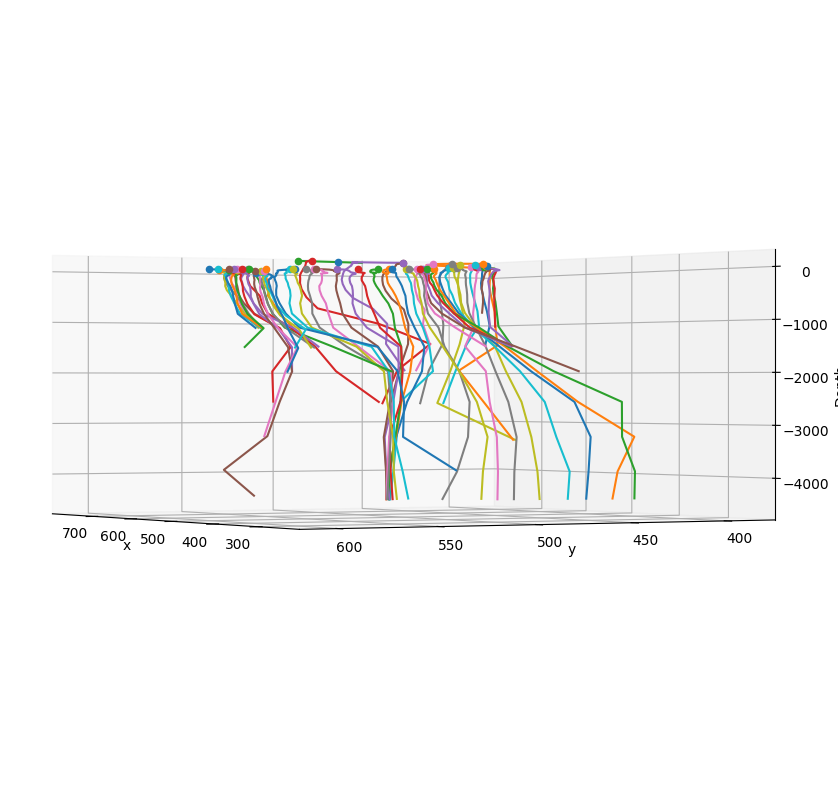

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for eddy in dic_sample:
    # if eddy in ['Eddy2749', 'Eddy2504']: Eddy896 Eddy382
    if eddy in ['Eddy382']:
        dic_eddy = dic_sample[eddy]
        for day in dic_eddy.keys():
            df = dic_eddy[day].copy()
            ax.scatter(df.iloc[0]['x'], df.iloc[0]['y'], df.iloc[0]['Depth'])
            ax.plot(df['x'], df['y'], df['Depth'])

ax.view_init(elev=0, azim=150)
ax.set_box_aspect((1, 1, .5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Depth')

plt.show()


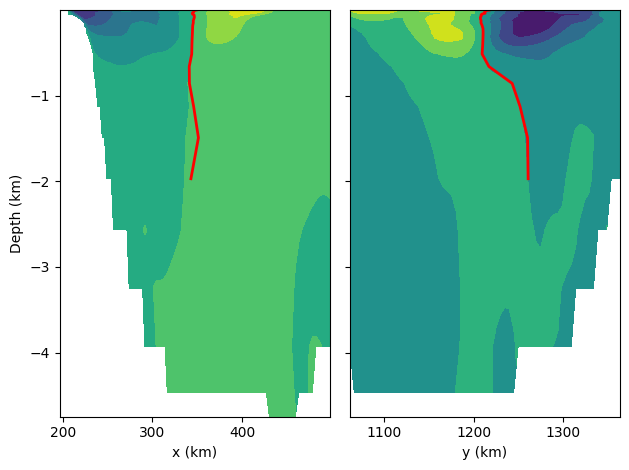

Day                                                   4423
ID                                                     896
Cyc                                                     AE
Lon                                             155.023692
Lat                                             -29.143249
ic                                                     133
jc                                                     246
x0                                               349.36281
y0                                             1216.847491
q11                                               0.007604
q12                                               0.000747
q22                                               0.003231
w                                                  0.02167
Age                                                     70
fname    /srv/scratch/z3533156/26year_BRAN2020/outer_av...
Name: 350, dtype: object

In [11]:
df_sample = df_eddies[df_eddies['ID'].isin(sample_eddies)].reset_index(drop=True)

p = 350

data = df_sample.loc[p]
eddy, day, ic_surf, jc_surf, fname = data['ID'], data['Day'], data['ic'], data['jc'], data['fname']

fnumber = fname[-8:-3]

with nc.Dataset(fname) as dataset:
    ocean_time = dataset.variables['ocean_time'][:].data / 86400
t_rel = np.where(ocean_time == day)[0][0]

u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
u_raw = np.where(u_raw > 1e30, np.nan, u_raw).astype(float)
v_raw = np.where(v_raw > 1e30, np.nan, v_raw).astype(float)

u, v = u_raw[:,:,:,t_rel], v_raw[:,:,:,t_rel]

df = dic_sample[f'Eddy{eddy}'][f'Day{day}'].copy()

i_left, i_right, j_down, j_up = grid_finder(X_grid, Y_grid, ic_surf, jc_surf, 150)

q11s, q12s, q22s = [], [], []
for k in range(len(df)):
    Q = df.loc[k]['Q']
    q11s.append(Q[0,0])
    q12s.append(Q[0,1])
    q22s.append(Q[1,1])
df['q11'], df['q12'], df['q22'] = q11s, q12s, q22s
df = df.drop(columns=['Q'])

fig, axs = plt.subplots(1, 2, sharey=True)

axs[0].contourf(x_grid[ic_surf-i_left:ic_surf+i_right], z_r[150,150,:]/1000, v[ic_surf-i_left:ic_surf+i_right, jc_surf, :].T)
axs[0].plot(df['x'], df['Depth']/1000, color='r', linewidth=2)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')

axs[1].contourf(y_grid[jc_surf-j_down:jc_surf+j_up], z_r[150,150,:]/1000, u[ic_surf, jc_surf-j_down:jc_surf+j_up, :].T)
axs[1].plot(df['y'], df['Depth']/1000, color='r', linewidth=2)
axs[1].set_xlabel('y (km)')
# axs[1].set_ylabel('Depth (km)')

plt.tight_layout()
plt.show()
data

In [12]:
df_sample.head()


Day  ID Cyc         Lon        Lat   ic  jc          x0          y0  \
0  1462   8  AE  152.688281 -35.490215  137  97  360.411851  479.919772   
1  1463   8  AE  152.679057 -35.601963  138  95  363.418874  467.973572   
2  1464   8  AE  152.671726 -35.616015  138  95  363.266403  466.280808   
3  1465   8  AE  152.782992 -35.518158  140  97  369.511186  479.932130   
4  1466   8  AE  152.655353 -35.508451  136  97  358.199587  476.998993   

        q11       q12       q22         w  Age  \
0  0.007108  0.003003  0.006968  0.028152  233   
1  0.006676  0.001111  0.006341  0.026034  233   
2  0.007177  0.001652  0.006417  0.027189  233   
3  0.005908  0.000886  0.005142  0.022100  233   
4  0.005040  0.000989  0.005770  0.021620  233   

                                               fname  
0  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
1  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
2  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
3  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
4  /srv/scratch/z3533156/26year_BRAN2020/outer_av...

## R2 Linear method

In [13]:
# Ensure required columns exist with correct dtype
for col in ['Top', 'Btm']:
    if col not in df_sample.columns or df_sample[col].dtype != 'object':
        df_sample[col] = pd.Series([np.nan] * len(df_sample), dtype=object)
if 'R2' not in df_sample.columns:
    df_sample['R2'] = np.nan

for eddy in sample_eddies:
    dic_eddy = dic_sample[f'Eddy{eddy}']
    
    for day, df in dic_eddy.items():
        df = df.copy()
        df[['x', 'y']] = df[['x', 'y']].astype(float)
        df[['x', 'y']] -= df.iloc[0][['x', 'y']]
        df['Depth'] = df['Depth'].astype(float) / 1000
        df['w'] = df['w'].astype(float)

        points = df[['x', 'y', 'Depth']].values.astype(float)
        weights = 1 / df['w'].values
        # weights = np.ones(len(df))
        weights /= weights.sum()

        centroid = np.average(points, axis=0, weights=weights)
        centered = points - centroid
        cov = (centered * weights[:, None]).T @ centered
        cov = cov.astype(float)

        _, _, Vt = np.linalg.svd(cov)
        direction = Vt[0]

        proj = centroid + np.outer((points - centroid) @ direction, direction)
        ss_res = np.sum(weights * np.sum((points - proj) ** 2, axis=1))
        ss_tot = np.sum(weights * np.sum(centered ** 2, axis=1))
        r2 = 1 - ss_res / ss_tot

        z_line = np.linspace(df['Depth'].min(), df['Depth'].max(), 3)
        t = (z_line - centroid[2]) / direction[2]
        x_line = centroid[0] + t * direction[0]
        y_line = centroid[1] + t * direction[1]

        top_point = (x_line[-1], y_line[-1], z_line[-1])
        btm_point = (x_line[0], y_line[0], z_line[0])

        mask = (df_sample['ID'] == eddy) & (df_sample['Day'] == int(day[3:]))
        idx = df_sample.index[mask]

        if len(idx) == 1:
            df_sample.at[idx[0], 'Top'] = top_point
            df_sample.at[idx[0], 'Btm'] = btm_point
            df_sample.at[idx[0], 'R2'] = r2


/scratch/pbs.6500974.kman.restech.unsw.edu.au/ipykernel_3563795/3120964162.py:34: RuntimeWarning: invalid value encountered in scalar divide
  r2 = 1 - ss_res / ss_tot
/scratch/pbs.6500974.kman.restech.unsw.edu.au/ipykernel_3563795/3120964162.py:37: RuntimeWarning: invalid value encountered in divide
  t = (z_line - centroid[2]) / direction[2]


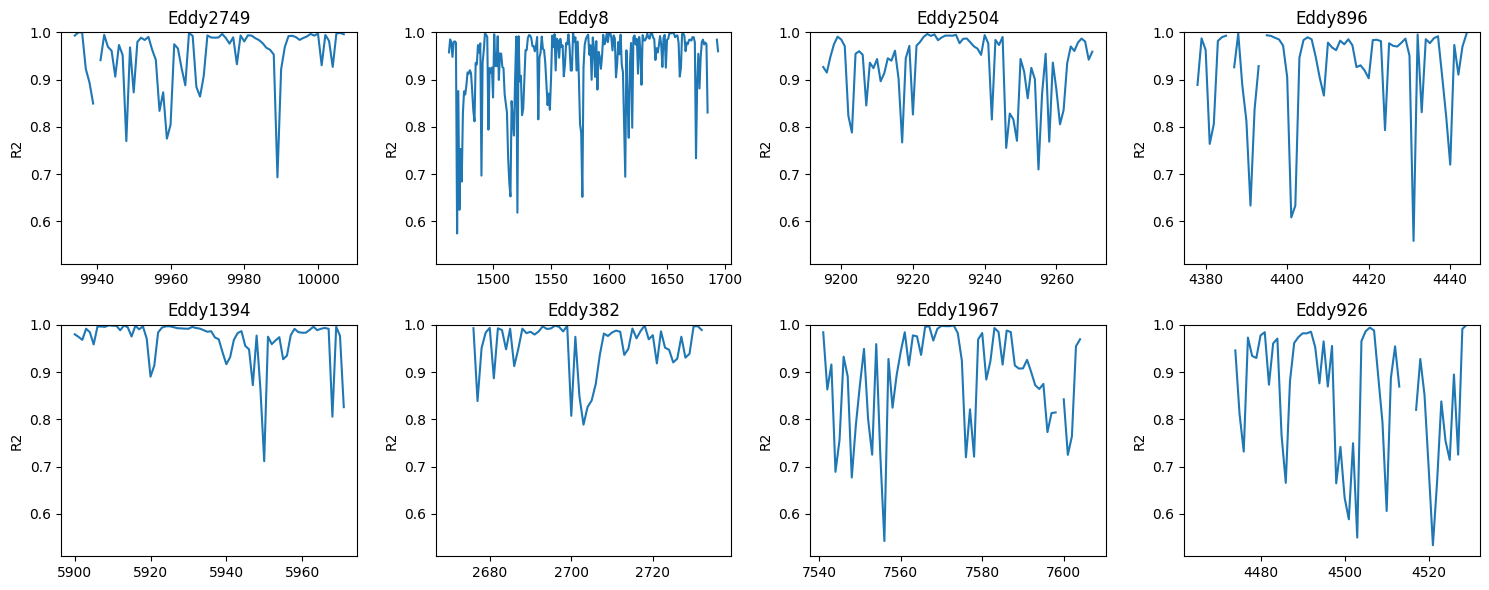

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(15,6))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    
    df = df_sample[df_sample['ID']==eddy]
    ax.plot(df['Day'], df['R2'])
    ax.set_title(f'Eddy{eddy}')
    ax.set_ylabel('R2')

ymin = min(ax.get_ylim()[0] for ax in axs.flat)
for ax in axs.flat:
    ax.set_ylim(ymin, 1)

plt.tight_layout()
plt.show()


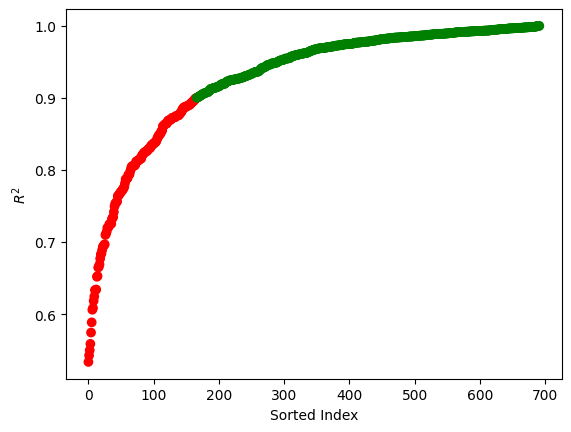

In [15]:
df_p = pd.DataFrame({'r2': np.sort(df_sample['R2'].tolist())})
df_p['c'] = np.where(df_p['r2'] >= 0.9, 'g', 'r')
plt.scatter(df_p.index, df_p['r2'], color=df_p['c'])
plt.xlabel('Sorted Index')
plt.ylabel(r'$R^2$')
plt.show()


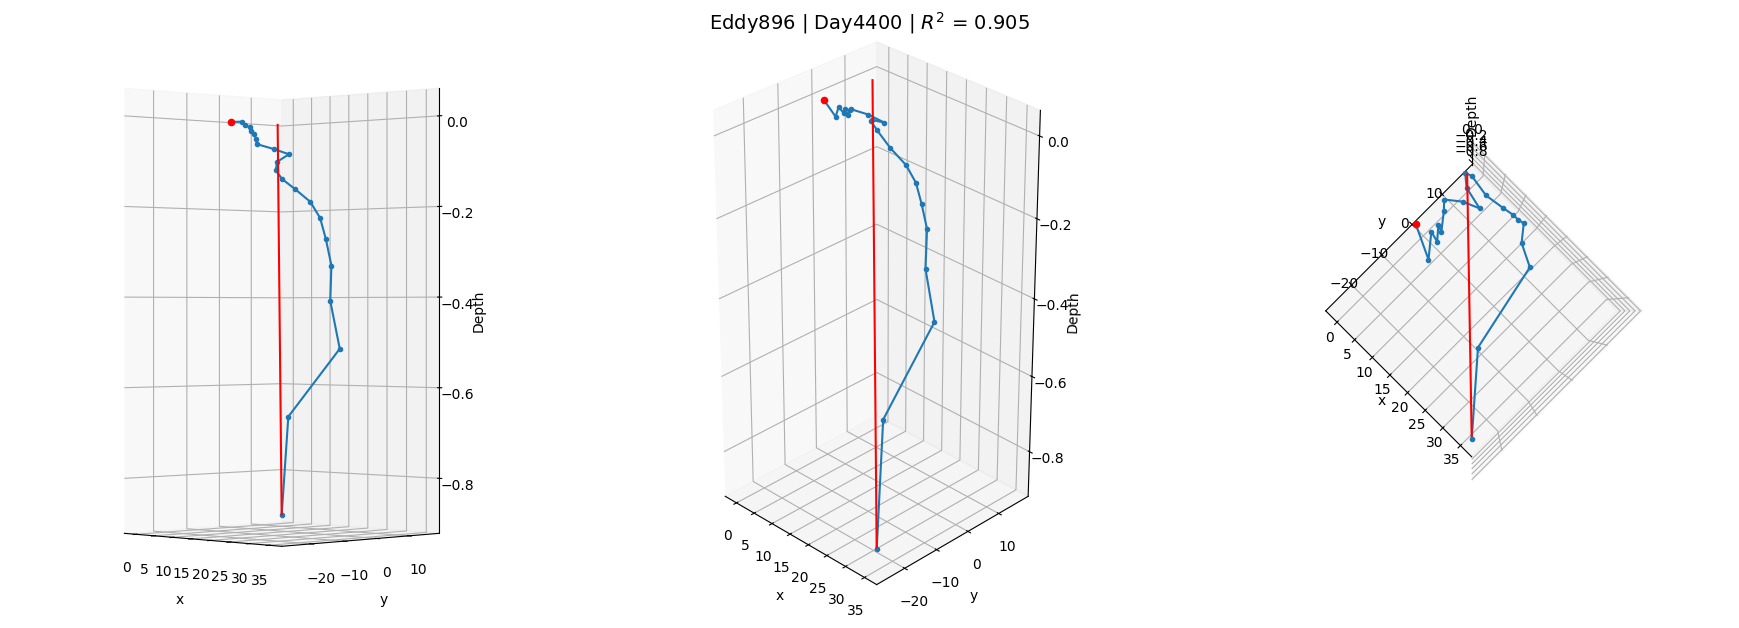

In [16]:
eddy = 'Eddy896'
t = 20

dic_eddy = dic_sample[eddy]

days = list(dic_eddy.keys())
day = days[t]

df = dic_eddy[day].copy()
df['x'] = df['x'] - df.iloc[0]['x']
df['y'] = df['y'] - df.iloc[0]['y']
df['Depth'] = df['Depth'] / 1000

df_line = df_sample[(df_sample['ID']==int(eddy[4:]))&(df_sample['Day']==int(day[3:]))]

top = df_line.iloc[0]['Top']
btm = df_line.iloc[0]['Btm']
r2 = df_line.iloc[0]['R2']

fig = plt.figure(figsize=(18, 6))  # Wider figure for 3 subplots
elevs = [0, 30, 90]

for i, elev in enumerate(elevs):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    ax.scatter(df.iloc[0]['x'], df.iloc[0]['y'], df.iloc[0]['Depth'], color='r')
    ax.plot(df['x'], df['y'], df['Depth'], marker='.')
    ax.plot([top[0], btm[0]], [top[1], btm[1]], [top[2], btm[2]], color='red')

    ax.view_init(elev=elev, azim=-45)
    ax.set_box_aspect((1, 1, 2))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Depth')
    # ax.set_title(f'Elev={elev}°')

fig.suptitle(f'{eddy} | {day} | $R^2$ = {r2:.3f}', fontsize=14)
plt.tight_layout()
plt.show()


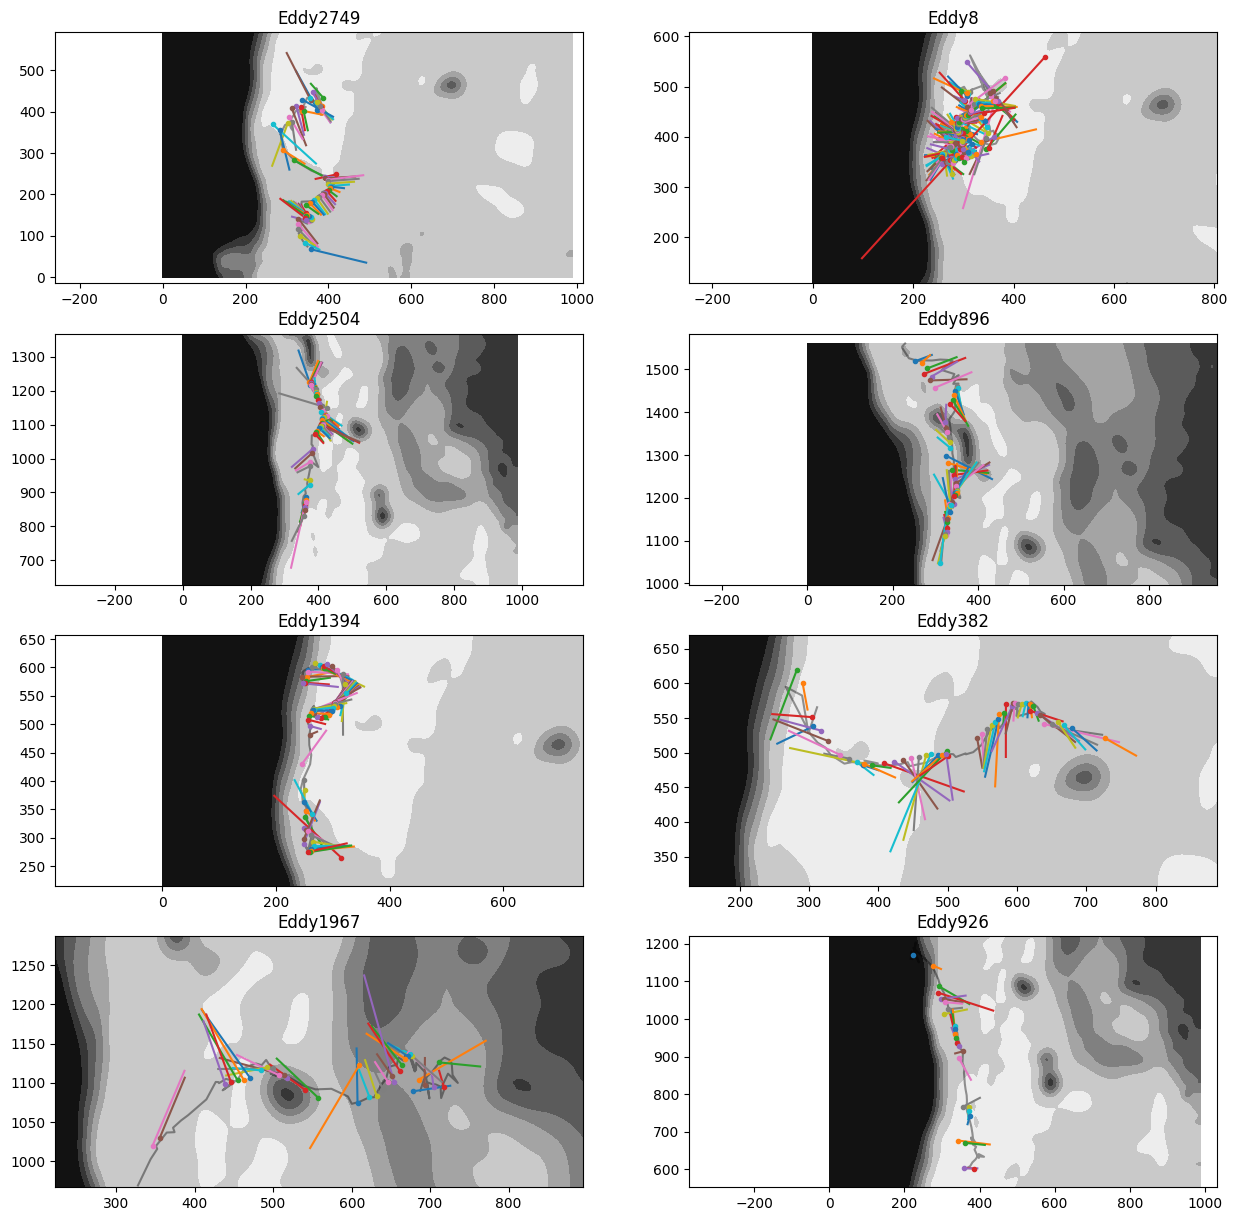

In [17]:

fig, axs = plt.subplots(4, 2, figsize=(15,15))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 2, e % 2]

    ax.contourf(X_grid, Y_grid, h/1000, cmap='gray')
    
    df = df_sample[df_sample['ID'] == eddy].copy()
    ax.plot(df['x0'], df['y0'], 'k', alpha=.4)
    
    df = df_sample[(df_sample['R2'] >= .9)&(df_sample['ID'] == eddy)].copy()
    xs, ys = [], []
    for (eddy, day, top, btm) in zip(df['ID'], df['Day'], df['Top'], df['Btm']):
    
        df_rel = dic_sample[f'Eddy{eddy}'][f'Day{day}'].copy()
        x_surf, y_surf = df_rel.iloc[0].x, df_rel.iloc[0].y
    
        xs.extend([top[0]+x_surf, btm[0]+x_surf])
        ys.extend([top[1]+y_surf, btm[1]+y_surf])
    
        ax.plot([top[0]+x_surf, btm[0]+x_surf], [top[1]+y_surf, btm[1]+y_surf])
        ax.scatter(top[0]+x_surf, top[1]+y_surf, marker='.', zorder=10)
    ax.axis('equal')
    ax.set_title(f'Eddy{eddy}')
    ax.set_xlim(np.min(xs)-50, np.max(xs)+50)
    ax.set_ylim(np.min(ys)-50, np.max(ys)+50)


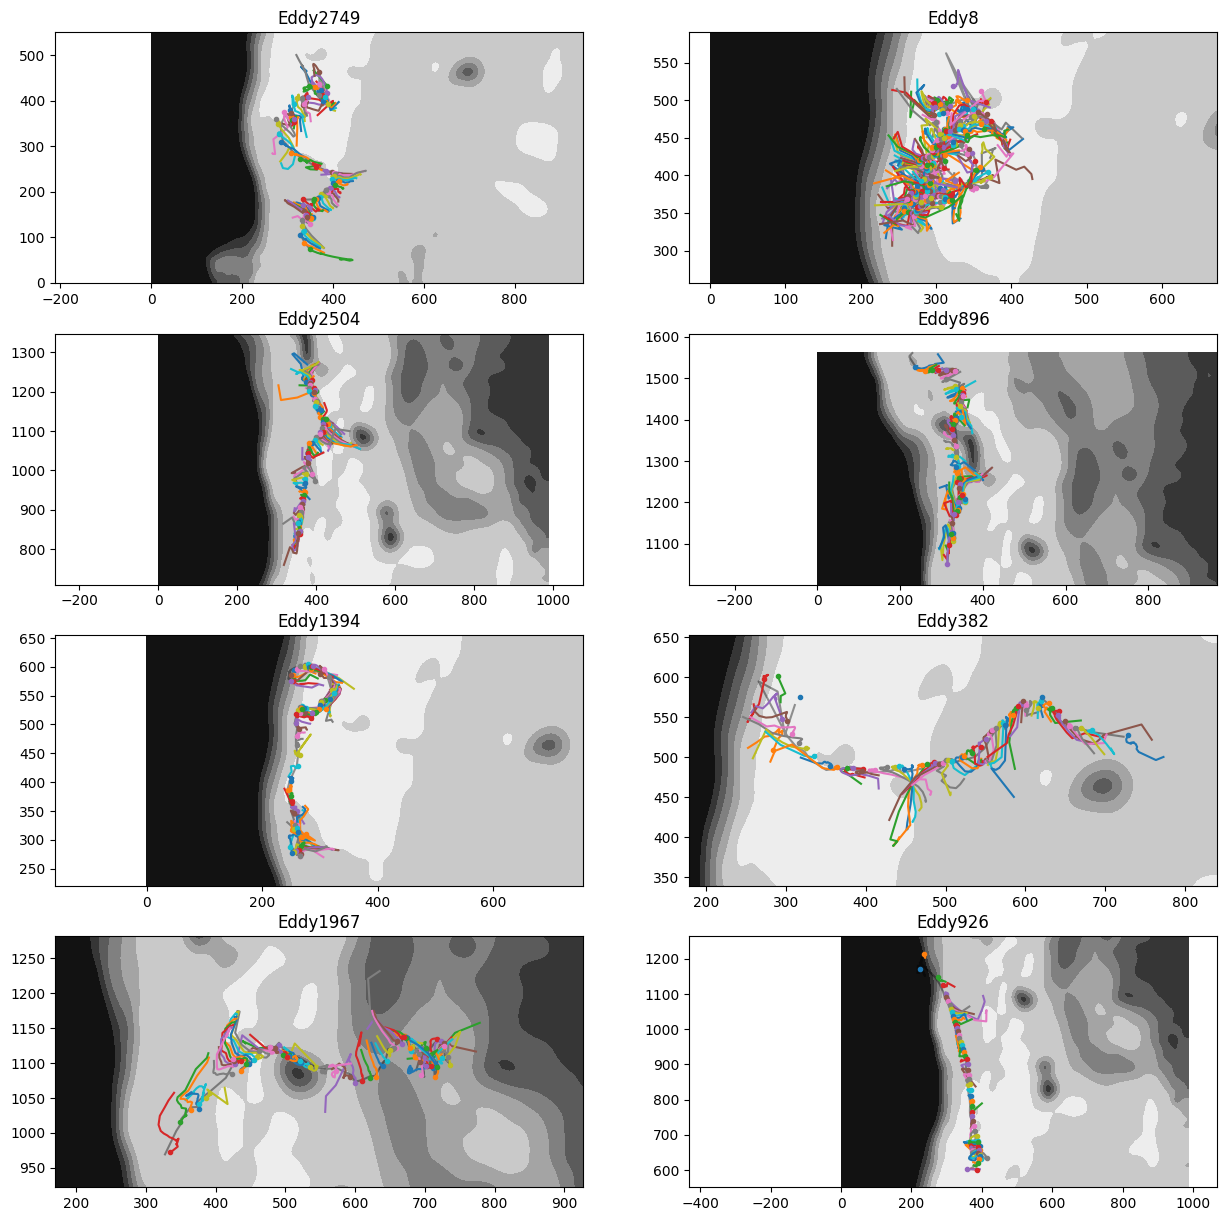

In [18]:
fig, axs = plt.subplots(4, 2, figsize=(15,15))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 2, e % 2]

    ax.contourf(X_grid, Y_grid, h/1000, cmap='gray')
    
    df = df_sample[df_sample['ID'] == eddy].copy()
    ax.plot(df['x0'], df['y0'], 'k', alpha=.4)
    
    xs, ys = [], []
    for (eddy, day, top, btm) in zip(df['ID'], df['Day'], df['x0'], df['y0']):

        if f'Day{day}' in dic_sample[f'Eddy{eddy}'].keys():
            df_rel = dic_sample[f'Eddy{eddy}'][f'Day{day}'].copy()
            x, y = df_rel.x, df_rel.y
        
            xs.extend(x)
            ys.extend(y)
        
            ax.plot(x, y)
            ax.scatter(x[0], y[0], marker='.', zorder=10)
    ax.axis('equal')
    ax.set_title(f'Eddy{eddy}')
    ax.set_xlim(np.min(xs)-50, np.max(xs)+50)
    ax.set_ylim(np.min(ys)-50, np.max(ys)+50)




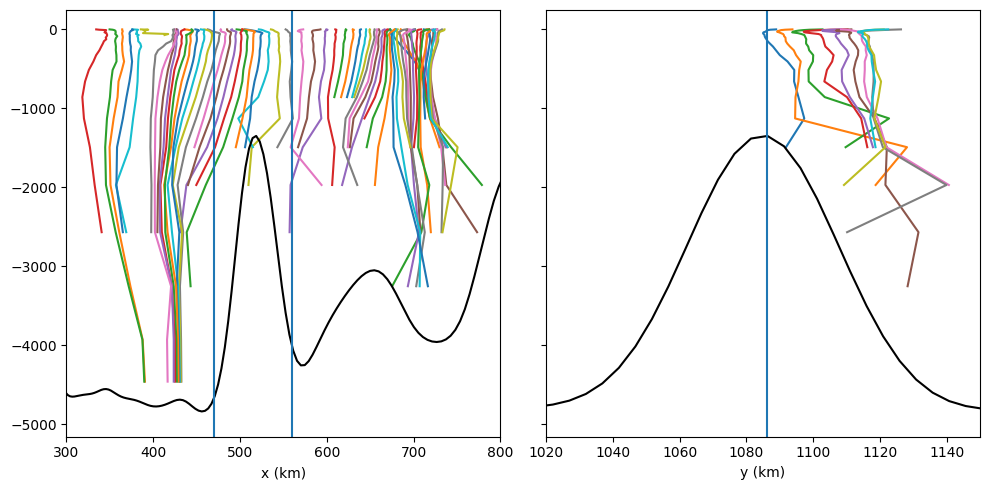

In [23]:
eddy = 1967

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

xmin1, xmax1 = 300, 800
y1 = 1085

xmin2, xmax2 = 470, 560
ymin2, ymax2 = 1020, 1150


df = df_sample[(df_sample['ID']==eddy)&(df_sample['x0']>=xmin1)&(df_sample['x0']<=xmax1)]
days = df['Day']
ys = []
for day in days: 
    if f'Day{day}' in dic_sample[f'Eddy{eddy}'].keys():
        df_rel = dic_sample[f'Eddy{eddy}'][f'Day{day}'].copy()
        ys.extend(df_rel.y)
        axs[0].plot(df_rel['x'], df_rel['Depth'])
    
# j = np.where(np.abs(np.mean(ys)-y_grid)==np.min(np.abs(np.mean(ys)-y_grid)))[0][0]
j = np.where(np.abs(y1-y_grid)==np.min(np.abs(y1-y_grid)))[0][0]
axs[0].plot(x_grid, -h[:,j], color='k')    

axs[0].axvline(x=xmin2)
axs[0].axvline(x=xmax2)
axs[0].set_xlim(xmin1, xmax1)
axs[0].set_xlabel('x (km)')


df = df_sample[(df_sample['ID']==eddy)&(df_sample['x0']>=xmin2)&(df_sample['x0']<=xmax2)&(df_sample['y0']>=ymin2)&(df_sample['y0']<=ymax2)]
days = df['Day']
xs = []
for day in days: 
    if f'Day{day}' in dic_sample[f'Eddy{eddy}'].keys():
        df_rel = dic_sample[f'Eddy{eddy}'][f'Day{day}'].copy()
        xs.extend(df_rel.x)
        axs[1].plot(df_rel['y'], df_rel['Depth'])
    
i = np.where(np.abs(520-x_grid)==np.min(np.abs(520-x_grid)))[0][0]

axs[1].plot(y_grid, -h[i,:], color='k')    
axs[1].axvline(x=y_grid[j])
axs[1].set_xlim(ymin2, ymax2)
axs[1].set_xlabel('y (km)')

plt.tight_layout()
plt.show()


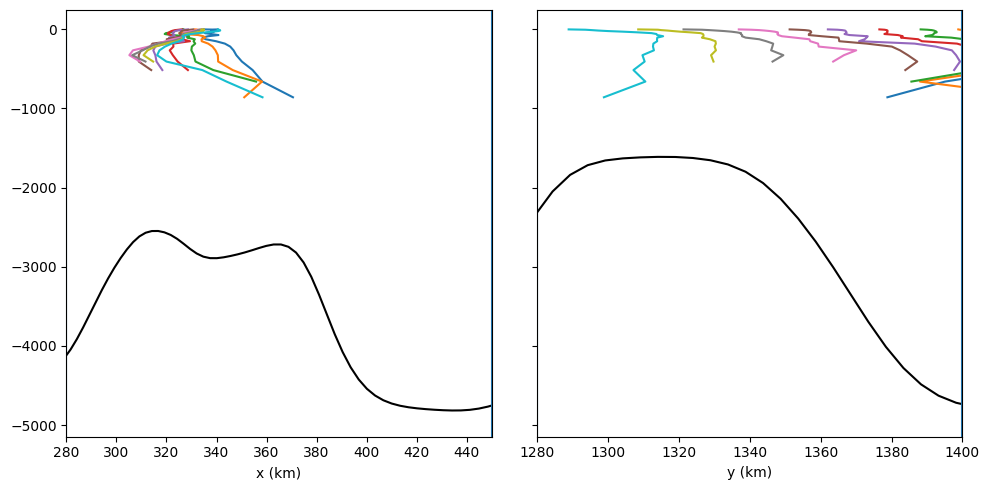

In [19]:
eddy = 896

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

xmin, xmax =  280, 450
ymin, ymax = 1280, 1400

df = df_sample[(df_sample['ID']==eddy)&(df_sample['y0']>=ymin)&(df_sample['y0']<=ymax)&(df_sample['x0']>=xmin)&(df_sample['x0']<=xmax)]
days = df['Day']
ys = []
for day in days: 
    if f'Day{day}' in dic_sample[f'Eddy{eddy}'].keys():
        df_rel = dic_sample[f'Eddy{eddy}'][f'Day{day}'].copy()
        ys.extend(df_rel.y)
        axs[0].plot(df_rel['x'], df_rel['Depth'])
    
j = np.where(np.abs(np.mean(ys)-y_grid)==np.min(np.abs(np.mean(ys)-y_grid)))[0][0]
# j = np.where(np.abs(y1-y_grid)==np.min(np.abs(y1-y_grid)))[0][0]
axs[0].plot(x_grid, -h[:,j], color='k')    

axs[0].axvline(x=xmin)
axs[0].axvline(x=xmax)
axs[0].set_xlim(xmin, xmax)
axs[0].set_xlabel('x (km)')

xs = []
for day in days: 
    if f'Day{day}' in dic_sample[f'Eddy{eddy}'].keys():
        df_rel = dic_sample[f'Eddy{eddy}'][f'Day{day}'].copy()
        xs.extend(df_rel.x)
        axs[1].plot(df_rel['y'], df_rel['Depth'])
    
i = np.where(np.abs(380-x_grid)==np.min(np.abs(380-x_grid)))[0][0]

axs[1].plot(y_grid, -h[i,:], color='k')    
axs[1].axvline(x=ymin)
axs[1].axvline(x=ymax)
axs[1].set_xlim(ymin, ymax)
axs[1].set_xlabel('y (km)')

plt.tight_layout()
plt.show()

(np.float64(0.0),
 np.float64(988.1356688684336),
 np.float64(0.0),
 np.float64(1561.702894718129))

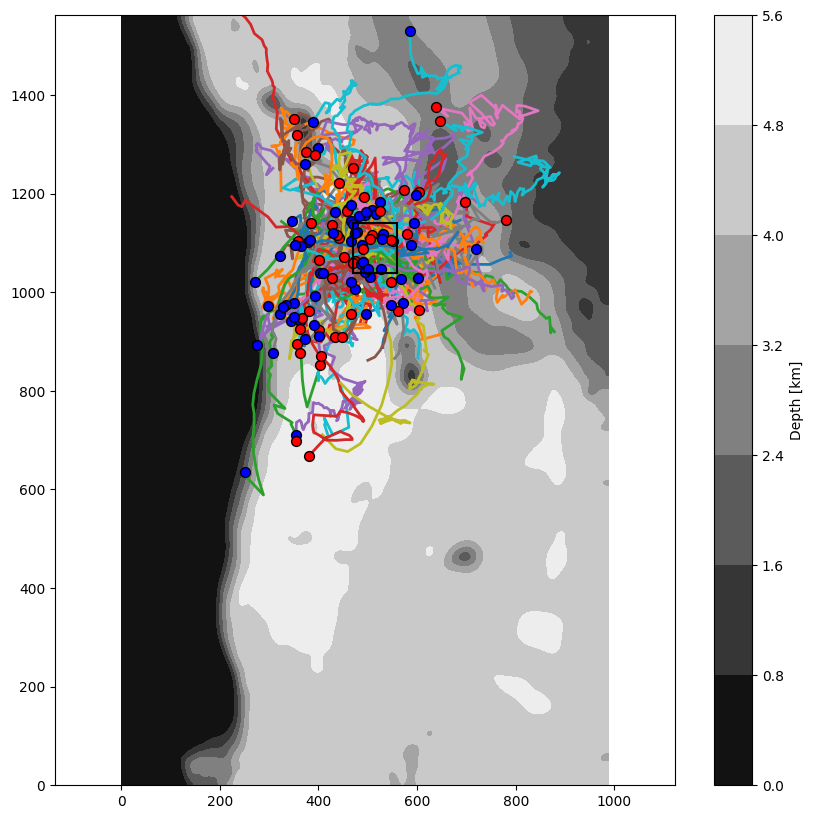

In [24]:
plt.figure(figsize=(10,10))
plt.contourf(X_grid, Y_grid, h/1000, cmap='gray')
plt.colorbar(label='Depth [km]')

x1, x2 = 470, 560
y1, y2 = 1040, 1140



df_knoll = df_eddies[(df_eddies['x0']>=x1)&(df_eddies['x0']<=x2)&
                        (df_eddies['y0']>=y1)&(df_eddies['y0']<=y2)]
for eddy in df_knoll['ID'].unique():
    df = df_eddies[df_eddies['ID']==eddy].copy()
    cyc = df.iloc[0].Cyc
    plt.plot(df['x0'], df['y0'], label=f'{cyc}{eddy}',
            linewidth=2)
    plt.scatter(df.iloc[-1]['x0'], df.iloc[-1]['y0'], edgecolors='k',
                color='r' if cyc=='AE' else 'b', zorder=10, s=50)


plt.plot([x1, x2], [y1, y1], zorder=1000, color='k')
plt.plot([x1, x2], [y2, y2], zorder=1000, color='k')
plt.plot([x1, x1], [y1, y2], zorder=1000, color='k')
plt.plot([x2, x2], [y1, y2], zorder=1000, color='k')

# plt.legend(loc='upper left', fontsize=14)
plt.axis('equal')
# plt.xlim(150, 160)
# plt.ylim(-40, -26)
# plt.xlabel('Longitude °E')
# plt.ylabel('Latitude °N')